# The main plot I am showing in this notebook is at the end

If not already installed (and running Anaconda) install the following:<br>
conda install plotly<br>
conda install geopandas<br>
conda install pyshp


Eventually the below will be handeled by an interface, but for now it is manual

In [147]:
# User chooses which features to include from the list of all available features
# These features are (Mean Income , Unemployment Rate , Rural-Urban Continuum Code , 
# Avg Num Of Sales , crime_rate_per_100000 , Avg Listing Price , Avg Listing Per Sqr Ft
# included_features = ['crime_rate_per_100000','Avg Listing Price','Mean Income','Rural-Urban Continuum Code',
#                     'Unemployment Rate']
included_features = ['Avg Listing Price','Rural-Urban Continuum Code','Unemployment Rate','Mean Income']

# For these selected features the user selects the optimal values they prefer
# Eventually this will be through a drop-down menu, but for now it is a lsit entered in the same order as the
# provided features above
feature_values_desired = [150000,6,5,95000]

# If desired you can choose to only select a subset of the country (by region)
# Region names are Northeast, Southeast, Midwest, Southwest, and West
region_select = [] # Brackets around selection

# Users also have the option to limit their selection to a single state, or search the entire country
# This will be done through an interface, but here it is using a single list
# If this list is empty it will select entire country, otherwise enter name as string in the list
# Note Rural-Urban Continuum Code goes from 1-9, with 1 being bustling city
state_select = []

# Below is the number of counties to display
num_counties = 0

# Select order to use for calculating Minkowski distance between counties
p=2

# Where processed files are saved to
processed_data_folder = '/Users/bryan/Movies/Data For TDI Project/Processed_Data_County_Level'
county_file_name = 'for_county_recommendations.csv'

Import All Modules

In [148]:
import pandas as pd
import os.path
from scipy.spatial.distance import minkowski
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt

import plotly
plotly.tools.set_credentials_file(username='bmoore49', api_key='xnI7D5RMqkWnQzD76tDx')
import plotly.plotly as py
import plotly.figure_factory as ff

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

In [149]:
# During EDA it was noted that there is an extremely strong correlation
# between Avg Listing Price and Avg Listing Per Sqr Ft
# To prevent this from causing signficant problems during the search below we will manually prevent the user from
# having selecting both
# For the final version this can be done directly through the interface, but here is is a check after the fact

if ('Avg Listing Price' in included_features) & ('Avg Listing Per Sqr Ft' in included_features):
    print('You must remove either Avg Listing Price or Avg Listing Per Sqr Ft from your selection')
    print('Both are not allowed as they will degrade your predictions')
    raise KeyboardInterrupt

Now load the data into memory

In [150]:
# Load dataframe with data for recommendations into memory
for_county_recommendations_df = pd.read_csv(os.path.join(processed_data_folder,county_file_name))
# Drop unnecessary column (artificat from being read in)
for_county_recommendations_df.drop(columns=['Unnamed: 0'], inplace=True)

for_county_recommendations_df.head()

,index,Mean Income,Unemployment Rate,Rural-Urban Continuum Code,Avg Num Of Sales,crime_rate_per_100000,Avg Listing Price,Avg Listing Per Sqr Ft,FIPS,StateName,CountyName
0,1.0,58343.0,3.9,2.0,180.490909,251.601926,200641.125000,101.445131,1001,Alabama,Autauga
1,2.0,56607.0,4.0,3.0,458.500000,228.086325,306246.250000,147.828333,1003,Alabama,Baldwin
2,3.0,32490.0,5.9,6.0,7.356602,177.278771,163670.833333,88.227731,1005,Alabama,Barbour
3,4.0,45795.0,4.4,1.0,4.666667,217.661692,144979.083333,87.040312,1007,Alabama,Bibb
4,5.0,48253.0,4.0,1.0,51.545455,210.810064,175120.833333,110.452846,1009,Alabama,Blount


In [151]:
# Run this only if region_select has been filled out and no list of specific states created
if (not(len(region_select))==0 and len(state_select)==0):
    
    if region_select==['Northeast']:
        state_select=['Maine','Massachusetts','Rhode Island','Connecticut','New Hampshire','Vermont','New York',
                      'Pennsylvania','New Jersey','Delaware','Maryland']
    if region_select==['Southeast']:
        state_select=['West Virginia','Virginia','Kentucky','Tennessee','North Carolina','South Carolina',
                      'Georgia','Alabama','Mississippi','Arkansas','Louisiana','Florida']
    if region_select==['Midwest']:
        state_select=['Ohio','Indiana','Michigan','Illinois','Missouri','Wisconsin','Minnesota','Iowa','Kansas',
                      'Nebraska','South Dakota','North Dakota']
    if region_select==['Southwest']:
        state_select=['Texas','Oklahoma','New Mexico','Arizona']
    if region_select==['West']:
        state_select=['Colorado','Wyoming','Montana','Idaho','Washington','Oregon','Utah','Nevada','California',
                      'Alaska','Hawaii']

In [152]:
# Make sure all provided states are in the dataframe
# Once this is done through an interface this will not be a problem, but for now we check manually

# First get list of all unique state names in the dataframe
states_in_df = for_county_recommendations_df.StateName.unique()

for item in state_select: # Go through each requested state and make sure it is in the list
    if not (item in states_in_df): # If not in list alert user
        print('The selected state (%s) is not in the dataframe' %item)
        print('Replace this selection with a valid name from the list states_in_df')
        raise KeyboardInterrupt

Now modify this dataframe if the user selected to limit it to only chosen states

In [153]:
# The above is run only if the list for selecting a state is not empty
if not (len(state_select)==0):
    # Only include entries corresponding to States provided by users
    for_county_recommendations_df = for_county_recommendations_df[for_county_recommendations_df.StateName.isin(state_select)]
    
# Now check how many counties are in list available for selection    
print('There are %i counties in database' %for_county_recommendations_df.shape[0])

There are 3137 counties in database


In [154]:
# If user selected 0 counties change this to include all counties in new database
if num_counties==0:
    num_counties = for_county_recommendations_df.shape[0]

We now restrict this dataframe to only hold the selected features for this comparison

In [155]:
# First, make separate dataframe with FIPS, StateName, and CountyName information
# This is not needed for finding most similar columns, but will be needed for displaying human-readable
# information to the user
county_info_df = for_county_recommendations_df[['FIPS','StateName','CountyName']]

# Now choose to only keep those features indicated above
feature_df = for_county_recommendations_df[included_features]
feature_titles = list(feature_df.columns.values)
feature_array = feature_df.values

Now implement PCA such that we work in a space where all features are indpendent

In [156]:
# Definition performs PCA and allows you to see amount of variance explained by new features
def view_pca_variance(feature_array):
    # Now Scale the feature matrix
    feature_array = StandardScaler().fit_transform(feature_array)

    # Find Eigenvalues and Eigenvectors
    cor_mat1 = np.corrcoef(feature_array.T)
    eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
    
    # Now plot the total variance explained by each feature in the new vector space
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    num_eig_pairs = len(eig_pairs)+1

    trace1 = dict(
        type='bar',
        x=['PC %s' %i for i in range(1,num_eig_pairs)],
        y=var_exp,
        name='Individual'
    )
    trace2 = dict(
        type='scatter',
        x=['PC %s' %i for i in range(1,num_eig_pairs)], 
        y=cum_var_exp,
        name='Cumulative'
    )
    data = [trace1, trace2]
    layout=dict(
        title='Explained variance by different principal components',
        yaxis=dict(
            title='Explained variance in percent'
        ),
        annotations=list([
            dict(
                x=1.16,
                y=1.05,
                xref='paper',
                yref='paper',
                text='Explained Variance',
                showarrow=False,
            )
        ])
    )
    fig = dict(data=data, layout=layout)
    
    return py.iplot(fig, filename='exploratory-vis-histogram')

In [157]:
# First add the users chosen vector to the feature matrix
feature_array = np.concatenate((np.asarray(feature_values_desired).reshape(1,-1),feature_array), axis=0)

# View outcome of PCA implementation
view_pca_variance(feature_array)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bmoore49/0 or inside your plot.ly account where it is named 'exploratory-vis-histogram'


Now, using this choose how many features to keep in the output feature matrix after PCA

In [158]:
def implement_pca(feature_array,num_include):
    # Now Scale the feature matrix
    feature_array = StandardScaler().fit_transform(feature_array)
    
    # Find Eigenvalues and Eigenvectors
    cor_mat1 = np.corrcoef(feature_array.T)
    eig_vals, eig_vecs = np.linalg.eig(cor_mat1)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
    
    eigenvector_length = feature_array.shape[1]
    
    matrix_w = np.empty(shape=(eigenvector_length,num_include))
    col_num = 0
    for i in range(num_include):
        matrix_w[:,col_num] = eig_pairs[col_num][1].reshape(eigenvector_length,1).flatten()
        col_num+=1
    
    # Now use this weight matrix to perform the transformation
    feature_array_proj = feature_array.dot(matrix_w)
    
    return feature_array_proj

In [159]:
####### Apply PCA to feature array ##############
feature_array = implement_pca(feature_array,4)

######## Apply only scaling to feature array ################
# scaler = StandardScaler().fit(feature_array.reshape(-1, 1))
# feature_values_desired = scaler.transform(feature_values_desired.reshape(-1, 1))
# feature_array = scaler.transform(feature_array)

feature_values_desired = feature_array[0,:]
feature_array = np.delete(feature_array,(0),axis=0)

Implement K-Means Clustering on the counties in the chosen dataset

In [160]:
# Implement standard k-means clustering
km = KMeans(n_clusters=2)
km.fit(feature_array)
k_mean_labels = km.labels_

# Implement spectral clustering using nearest neighbors
sp = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
sp.fit(feature_array)
k_mean_spectral_labels = sp.labels_

We now calculate the minkowski distance between our provided row and each row in the dataframe and see which rows are the closest matches for the indicated features<br>
Note that the order of features will have been re-ordered to be in the same order as the supplied values above

In [161]:
# First calculate all distances between our supplied vector and every vector in our list
# Out of this we get a tuple for each calculation. First value in Tuple Holds calculated distance and second
# holds its corresponding index, third is k-means class, 4th is spectral clustering class
all_dist = [(minkowski(feature_values_desired,feature_array[row,:],p),
             row,k_mean_labels[row],k_mean_spectral_labels[row]) for row in range(feature_array.shape[0])]

# This orders the closest distances so they are at the front of the list
# Each entry is a tuple. The first item holds the distance and the second the corresponding index
sorted_counties = sorted(all_dist, key=lambda x: x[0])

# Now select to only keep the desired number of most similar counties
sorted_counties = sorted_counties[:num_counties]
# Get list of corresponding indices
distance_metric = [tuples[0] for tuples in sorted_counties]

sorted_counties_indices = [int(tuples[1]) for tuples in sorted_counties]

# Now find list of associated FIPS numbers
FIPS_vec = county_info_df.FIPS.values
# Get list of FIPS values corresponding to found indices
FIPS_values = FIPS_vec[sorted_counties_indices]

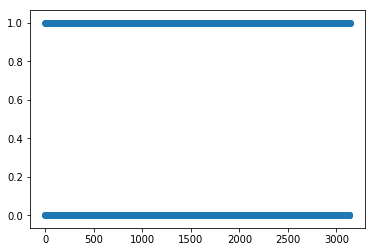

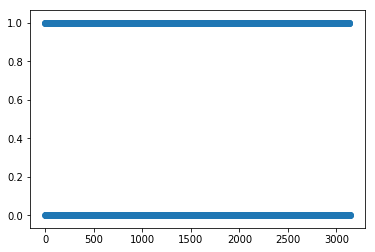

In [162]:
ordered_kmeans = [currVec[2] for currVec in all_dist]
ordered_spectral_clusters = [currVec[3] for currVec in all_dist]
plt.scatter(list(range(len(ordered_kmeans))),ordered_kmeans)
plt.show()
plt.scatter(list(range(len(ordered_spectral_clusters))),ordered_spectral_clusters)
plt.show()

Trying clusters of 2,3,4, or 5 groups shows no relationship for either clustering approach with the euclidean distances, which are believed to be somewhat correct based on user voting

In [163]:
# Now scale these values so max value is 1
distance_score = [float(score)/max(distance_metric) for score in distance_metric]

We will now correlate these counties with the associated information for human readability<br>
Below we output this as a pandas dataframe with the county and state names, along with the above-calculated score

In [164]:
# Create new dataframe with this information
recommended_counties_df = pd.DataFrame()

# Add in corresponding FIPS Values
recommended_counties_df['FIPS'] = FIPS_values
# Now add in the scores correlated with these FIPS values
recommended_counties_df['Closeness Score'] = distance_score
# Now insert corresponding information about which county and state this corresponds to
recommended_counties_df = pd.merge(recommended_counties_df,for_county_recommendations_df[['FIPS','StateName','CountyName']+included_features],how='outer',on='FIPS')
# Now drop all rows which recommendations were not made for
recommended_counties_df.dropna(inplace=True)
recommended_counties_df.reset_index(inplace=True)


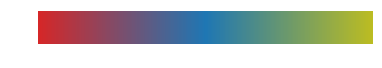

In [165]:
# Here we create a custom colormap to use for plot

import matplotlib. pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

def display_cmap(cmap): #Display  a colormap cmap
    plt.imshow(np.linspace(0, 100, 256)[None, :],  aspect=25, interpolation='nearest', cmap=cmap) 
    plt.axis('off')
    
def colormap_to_colorscale(cmap,num_steps):
    #function that transforms a matplotlib colormap to a Plotly colorscale
    step_size = 1/num_steps
    return [ [k*step_size, colors.rgb2hex(cmap(k*step_size))] for k in range(num_steps+1)]

def colorscale_from_list(alist, name,num_steps): 
    # Defines a colormap, and the corresponding Plotly colorscale from the list alist
    # alist=the list of basic colors
    # name is the name of the corresponding matplotlib colormap
    
    cmap = LinearSegmentedColormap.from_list(name, alist)
    display_cmap(cmap)
    colorscale=colormap_to_colorscale(cmap,num_steps)
    return cmap, colorscale

## Below is the codes for common colors
muted_blue = '#1f77b4'
safety_orange = '#ff7f0e'
cooked_asparagus_green = '#2ca02c'
brick_red = '#d62728'
muted_purple = '#9467bd'
chestnut_brown = '#8c564b'
rasberry_yogurt_pink = '#e377c2'
middle_gray = '#7f7f7f'
curry_yellow_green = '#bcbd22'
blue_teal = '#17becf'

input_colors = [brick_red,muted_blue,curry_yellow_green]
# input_colors = ['#32924c',  '#d7df84', '#91511e'] # Green to Yellow to Brown
# input_colors = ['#df0101', '#f5f6ce','#31b404'] # Red to Yellow to Green
# input_colors = ['#df0101', '#f5f6ce'] # Red to Yellow
# input_colors = ['#df0101',"#08306b"] # Red to Blue
# input_colors = ['#9467bd','#bcbd22'] # Purple to Yellow/Green
num_bins = 20
elev_cmap, elev_cs = colorscale_from_list(input_colors, 'elev_cmap',num_bins)
colorscale = [item[1] for item in elev_cs]

In [166]:
# Anything above the below percentage will be shown as same (helps show greater detail of other counties)
max_val_percentage = 0.25 # For Michigan

fips = FIPS_values
values = distance_score
endpts = list(np.linspace(min(values), max(values)*max_val_percentage, num_bins - 1))

# If user only wants to see results in a single state display only that state
if len(state_select)==1:
    disp_scope = state_select
else:
    disp_scope = ['usa']

fig = ff.create_choropleth(
    county_outline={'color': 'rgb(15, 15, 55)', 'width': 0.5},
    state_outline={'width': 1},
    fips = fips, values = values, scope = disp_scope,
    binning_endpoints = endpts,
    colorscale=colorscale,
    show_state_data = True,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'Map of Recommended Counties (Lower Score Means Better Match)',
    legend_title = 'Distance Score'
)
py.iplot(fig, filename = 'County Recommendation Plot')
# plotly.io.write_image(fig, 'county_map.png')

The draw time for this plot will be slow for all clients.


Please note that if the above figure does not load (as I have been seeing problems with it being rendered online) that there are representative plots in the folder here:<br>
https://github.com/moorebryan/county-recommendation-engine/tree/master/plots

In [167]:
print('Below are the top 20 counties in the selected region (with requested information):')
recommended_counties_df.drop(columns=['index','FIPS'],inplace=True)
# Convert Avg Listing Price to integer
recommended_counties_df['Avg Listing Price'] = [int(value) for value in recommended_counties_df['Avg Listing Price'].values]
recommended_counties_df.head(20)

Below are the top 20 counties in the selected region (with requested information):


,Closeness Score,StateName,CountyName,Avg Listing Price,Rural-Urban Continuum Code,Unemployment Rate,Mean Income
0,0.064809,North Dakota,Mercer,199683,7.0,4.0,82991.0
1,0.075592,Wyoming,Campbell,220187,5.0,4.9,78240.0
2,0.080465,Nevada,Lander,146922,7.0,4.5,75943.0
3,0.087966,Wyoming,Sweetwater,233137,5.0,4.6,75590.0
4,0.087973,Virginia,King George,333733,6.0,4.0,86878.0
5,0.089043,Alaska,Juneau,356929,5.0,4.7,90436.0
6,0.099074,Nevada,Elko,261835,5.0,3.7,76439.0
7,0.103041,Connecticut,Litchfield,302491,4.0,4.3,77968.0
8,0.104360,Maryland,Saint Marys,299252,3.0,4.0,82433.0
9,0.106653,South Dakota,Union,290883,3.0,3.7,82100.0
